In [1]:
import sklearn
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline 

# Fake job. Обучение нейронной сети
Задача заключается в определении по имеющимся данным настоящее объявление о работе или нет. Обучить на данных полносвязную (неглубокую) нейронную сеть

## Загрузка датасета

Используем подготовленный датасет из пред. задания:

In [2]:
data = pd.read_csv('fake_job_data_norm.csv', index_col=[0])
data.reset_index(drop=True, inplace=True)

In [3]:
data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.0,1.0,0.0,0.25,0.833333,0.083333,0.170543,0.861111,0.0
1,0.0,1.0,1.0,0.25,0.833333,0.083333,0.387597,0.444444,0.0
2,0.0,1.0,1.0,0.25,0.833333,0.416667,0.682171,0.555556,0.0
3,0.0,1.0,0.0,0.75,0.333333,0.333333,0.302326,0.194444,0.0
4,0.0,0.0,0.0,0.25,0.833333,0.083333,0.441860,0.500000,0.0
...,...,...,...,...,...,...,...,...,...
8129,0.0,1.0,0.0,0.25,0.333333,0.750000,0.403101,0.861111,0.0
8130,0.0,1.0,1.0,0.25,0.833333,0.083333,0.860465,0.388889,0.0
8131,0.0,0.0,0.0,0.25,0.833333,0.083333,0.170543,0.500000,0.0
8132,0.0,1.0,1.0,0.25,0.833333,0.083333,0.465116,0.000000,0.0


## Подготовка выборки

Разобьем данные на обучающую и тестовую выборки - 70% и 30%.

Из-за несбалансированности классов используем оверсэмплинг недостающего класса.

In [4]:
y=data['fraudulent']

X = data.drop(['fraudulent'],axis=1)

from imblearn.over_sampling import RandomOverSampler
rs=RandomOverSampler(sampling_strategy='minority')
X_over,y_over=rs.fit_resample(X,y)
X_over.describe()
y_over.describe()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 12)

## Обучаем классификатор

In [5]:
mlp_model = MLPClassifier(hidden_layer_sizes = (15,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42, 
                          max_iter=5000)

In [6]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 7.83 s


MLPClassifier(activation='logistic', hidden_layer_sizes=(15,), max_iter=5000,
              random_state=42, solver='lbfgs')

In [7]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

0.8991095198751492

In [8]:
accuracy_score(y_test, y_test_pred)

0.8920539730134932

## Подбор гиперпараметров

Найдем оптимальное значение параметра регуляризации alpha

In [9]:
alpha_arr = np.logspace(-3, 2, 20)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (10,), 
                              solver = 'lbfgs', 
                              activation = 'logistic', 
                              max_iter=5000, 
                              random_state = 40)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

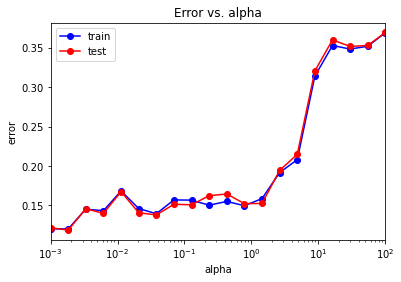

In [10]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

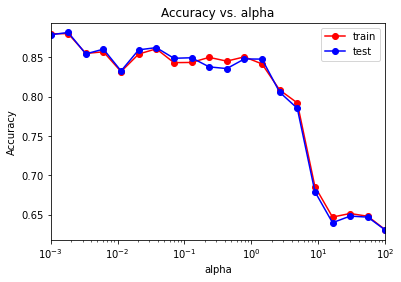

In [11]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Наибольшая точность при небольших значениях параметра

In [12]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Минимальное значение ошибки:',min_train_err, min_test_err)

Минимальное значение ошибки: 0.12016891581749747 0.11865495823516813


In [13]:
alpha_opt = alpha_arr[test_err == min_test_err][0]
print('Оптимальное значение alpha:',alpha_opt)

Оптимальное значение alpha: 0.0018329807108324356


## Подбор количества нейронов

Подберем оптимальное количество нейронов в нейронной сети при оптимальном значении alpha

In [14]:
neuron_arr = (np.linspace(1, 30, 15)).astype(int)
test_err = []
train_err = []
train_acc = []
test_acc = []

for neuron in neuron_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron,), 
                              solver = 'lbfgs', 
                              activation = 'logistic', 
                              max_iter=10000, 
                              random_state = 40)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

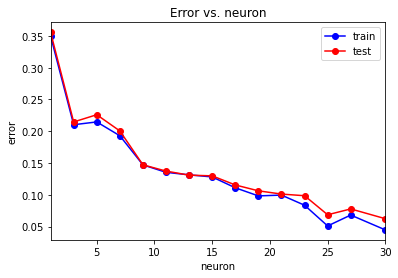

In [15]:
plt.plot(neuron_arr, train_err, 'b-o', label = 'train')
plt.plot(neuron_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. neuron')
plt.xlabel('neuron')
plt.ylabel('error')
plt.legend()

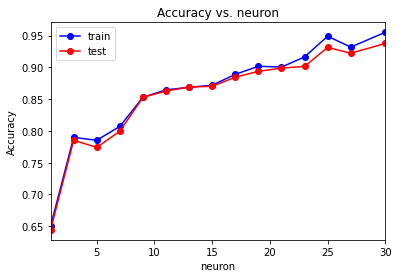

In [16]:
plt.plot(neuron_arr, train_acc, 'b-o', label = 'train')
plt.plot(neuron_arr, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Accuracy vs. neuron')
plt.xlabel('neuron')
plt.ylabel('Accuracy')
plt.legend()

С ростом числа нейронов наблюдается увеличение точности

In [17]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Минимальное значение ошибки:',min_train_err, min_test_err)

Минимальное значение ошибки: 0.04470761039199486 0.06232597986720925


In [18]:
neuron_opt = neuron_arr[test_err == min_test_err][0]
print('Оптимальное количество нейронов:',neuron_opt)

Оптимальное количество нейронов: 30


## Классификатор при найденных параметрах (alpha и кол-во нейронов)

In [19]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 40, max_iter=10000)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print('Итоговая точность:')
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

Итоговая точность:
0.9552923896080051
0.9376740201327908


## Матрица рассогласования:

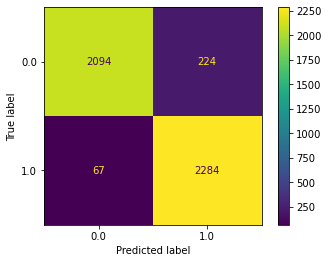

In [20]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

## Выводы:

В однослойной нейронной сети с относительно небольшим кол-ом нейронов(30) и опт. параметром  удалось добиться высокой точности (0.95 и 0.93 на тестовой). Получилось несколько меньше, чем в KNN (0.97 и 0.95). Судя по графику 'Accuracy vs. neuron' можно предположить, что увеличения точности можно добиться увелич. кол-ва нейронов в слое